<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_Coupled_Oscillator/blob/main/Lab3_Coupled_Oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3. Coupled oscillator

Evgeny Kolonsky, November 2023

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import requests
from scipy.signal import find_peaks, peak_prominences
from scipy.stats import linregress

In [2]:
def get_peaks(t, signal, show=False):
  rate = np.median(np.diff(t))
  min_period = 0.2 #s
  min_prominence = np.max(signal)*0.75
  peaks, _ = find_peaks(signal, prominence=min_prominence,
                        distance=min_period/rate )
  if show:
    plt.plot(signal)
    plt.plot(peaks, signal[peaks], "x")
    plt.grid()
  return peaks

def get_frequency(t, signal):
  peaks = get_peaks(t, signal)
  periods = np.diff(t[peaks])
  f0 = 1 / periods
  return np.mean(f0), np.std(f0)

def get_amplitude(t, signal, show=False):
  peaks = get_peaks(t, signal)
  return t[peaks], signal[peaks]

def get_frequency_fft(t, x, show=False):
  # get maximum  in Fast Fourie Transform spectrum
  X = np.fft.fft(x, n=10000)
  sr = 1/ np.diff(t).mean()
  N = len(X)
  T = N/sr
  freqs = np.arange(N)/T
  magnitude = np.abs(X)
  f0 = freqs[np.argmax(magnitude)]
  if show:
      plt.stem(freqs, magnitude, 'b', \
      markerfmt=" ", basefmt="-b")
      plt.xlabel('Freq (Hz)')
      plt.ylabel('magnitude [a.u]')
      plt.xlim(0.1, 2.2)
      #plt.axvline(f0, c='r')
      plt.annotate(fr'Max ={f0:.2f}Hz',xy=(f0, 10))
      # Show expected eigen frequencies
      for freq in freqs_theor:
        plt.axvline(freq, c='g')
        plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, 25))
  return f0


# 1-dof oscillator quality factor

In [3]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left and right springs
weight = 68.6e-3
k = weight * g /l
mk = 17e-3 # kg

# Carts
m = 208.9e-3 #kg

#Effective
m_eff = m + mk
k_eff = 2 * k

counts = 236
length = 123e-3

omega0 = np.sqrt(k_eff / m_eff)
freq_theor = omega0 /2 /np.pi
print(f'Estimated natural frequency {freq_theor:.1f} Hz')

Estimated natural frequency 1.2 Hz


In [4]:
def get_signal1(url, show=True):
  data = np.loadtxt(url)
  _, t, a = data.T
  x1 = a/counts * length
  x1 -= x1.mean()
  #filter = t < 3
  #t = t[filter]
  #x1 = x1[filter]
  #x2 = x2[filter]
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return t, x1

def get_signal2(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b = data.T
  x1 = a/counts * length
  x1 -= x1.mean()
  x2 = b/counts * length
  x2 -= x2.mean()
  #filter = t < 3
  #t = t[filter]
  #x1 = x1[filter]
  #x2 = x2[filter]
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t, x2, label='Cart B')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return t, x1, x2

def get_signal(url, show=True):
  return get_signal2(url, show)

### Quality factor

http://spiff.rit.edu/classes/phys283/lectures/forced_ii/forced_ii.html

Equation
$$
m \ddot x + b \dot x + k x = 0
$$
Solution
$$
x(t) = A e^{-t/\tau} \cos \omega_ t
$$
Quality factor definition
$$
Q \equiv \frac{\tau \omega_0}{2}
$$
Number of oscillations for amplitude to decat by $1/e$:
$$
N = Q/\pi
$$
Decay in amplitude in one cycle
$$ e^{-\pi/Q}$$.

In [5]:
def get_quality(t, harmonic_signal):
  tpeaks, peaks = get_amplitude(t, harmonic_signal)
  decay = np.log(peaks/peaks[0])
  cycles = range(len(peaks))
  fit = linregress(cycles, decay)
  quality = -np.pi/fit.slope
  return quality

def get_quality(t, harmonic_signal, show=False):
  tpeaks, peaks = get_amplitude(t, harmonic_signal)
  decay = np.log(peaks / peaks[0])
  cycles = range(len(peaks))
  fit = linregress(cycles, decay)
  quality = -np.pi/fit.slope
  N = quality / np.pi
  if show:
    plt.plot(cycles, decay, 'o', label='Measurements')
    plt.plot(cycles, fit.slope*cycles + fit.intercept, label=fr'Fit $Q=\pi*N$: {quality:.1f}')
    plt.xlabel(rf'$N$ = {N:.1f} cycles for $1/e$ decay')
    plt.ylabel('Log amplitude decay')

    ytix = np.unique(decay).astype(int)
    xtix = np.unique(ytix / fit.slope).astype(int)
    plt.yticks(ytix)
    plt.xticks(xtix)

    plt.grid()
    plt.legend()
  return quality

### Synthetic sample

Q extracted from the signal: 30.957566560600448
Q by definition: 31.400000000000002


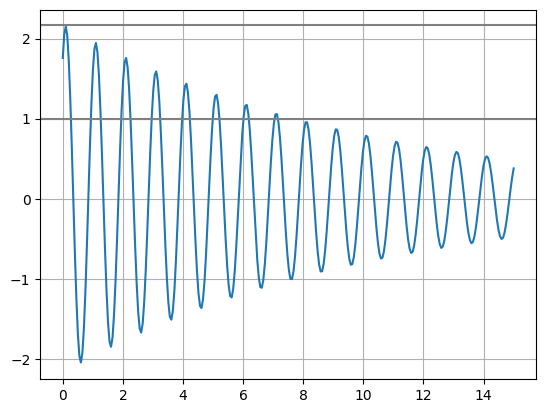

In [6]:
tau = 10
om = 6.28
tt = np.linspace(0, tau*1.5, 300)
xx = 2.171828 * np.exp(-tt/tau) * np.cos(om * (tt-0.1))
plt.plot(tt, xx)
plt.axhline(2.171828,  color='gray', xmin=0, xmax=1, label='e')
plt.axhline(1, color='gray', label='1')
plt.grid()
print('Q extracted from the signal:', get_quality(tt,xx))
print('Q by definition:', tau * om /2)

array([ 22,  42,  62,  82, 102, 122, 142, 161, 181])

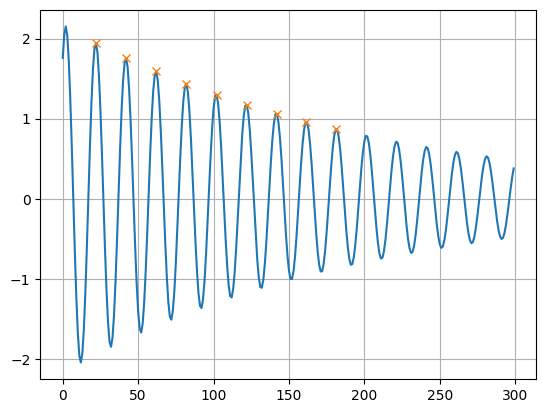

In [7]:
get_peaks(tt,xx, True)

30.957566560600448

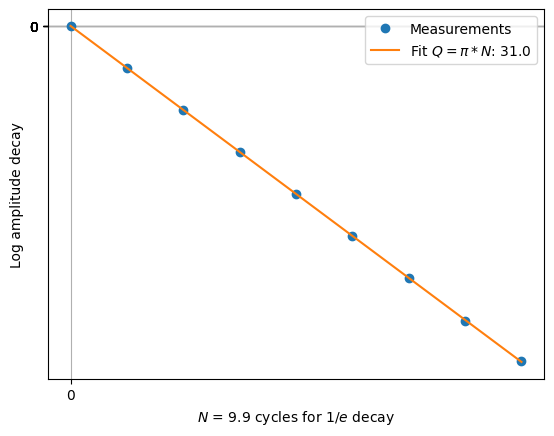

In [8]:
get_quality(tt,xx, True)

### 1-dof Q experiment: free dumped oscillations

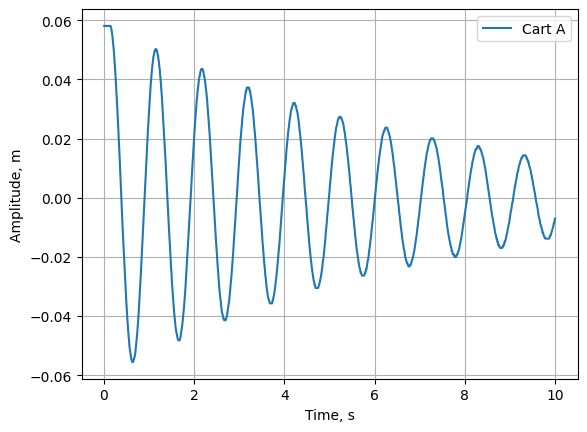

In [9]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/quality/q_1.txt'
t, x = get_signal1(url)

In [10]:
Q = get_quality(t,x)

### 1-dof Q experiment: forced oscillations - steady state

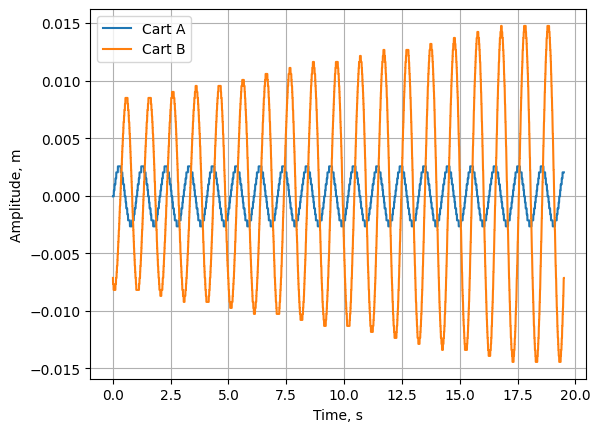

In [11]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/quality/q_2.txt'
t, force, oscillator = get_signal2(url)
_, af = get_amplitude(t, force)
_, ao = get_amplitude(t, oscillator)

Amplitude responce at resonance
$$
\frac{A}{A_0} = \frac{\omega_0^2 }{\sqrt{(\omega_0^2 - \omega^2)^2 + (\omega_0 \omega/Q)^2}}
$$

In [12]:
def responce(freq0, freq, quality):
  omega0 = freq0 * 2 * np.pi
  omega  = freq * 2 * np.pi
  factor = omega0**2  /np.sqrt(((omega0**2 - omega**2)**2 + (omega0 * omega /quality)**2))
  return factor

In [13]:
# is this resonance?
print('Force fr, Hz', get_frequency(t, force))
print('Oscil fr, Hz', get_frequency(t, oscillator))


Force fr, Hz (0.9849640339720016, 0.003431822480955129)
Oscil fr, Hz (0.9871399069681451, 0.005194597879261736)


Text(0, 0.5, 'Responce, A/A0, unitless')

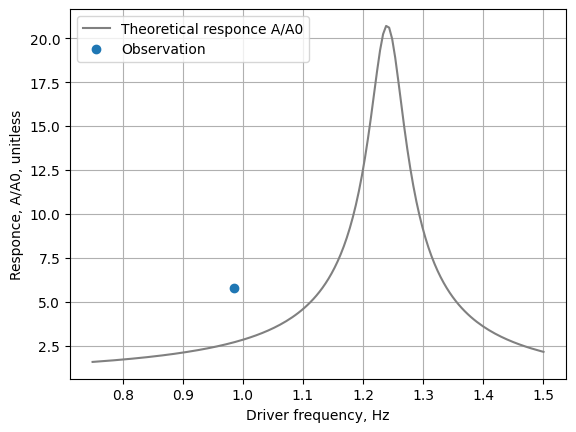

In [14]:
#responce(freq_theor, get_frequency(t, force)[0], Q)
f_dense = np.linspace(0.75, 1.50, 150)
plt.plot(f_dense, responce(freq_theor, f_dense, Q), '-', color='gray', label='Theoretical responce A/A0')
fr = get_frequency(t, force)[0]
resp = np.max(ao) / np.max(af)
plt.plot(fr, resp, 'o', label='Observation')
plt.grid()
plt.legend()
plt.xlabel('Driver frequency, Hz')
plt.ylabel('Responce, A/A0, unitless')

### 1-dof Amplitude as a function of driving displacement $\eta(t) = \eta_0 \cos \omega t$

$$
m \ddot x  + (k_1+k_2) x - b\dot x = k_1 \eta
$$
Solution
$$
x(t) = C \cos\omega t
$$
Quality $Q$ is considered to be known
$$
k \equiv k_1+k_2, \\
\omega_0^2 \equiv k/m,
Q \equiv \tau \omega_0 /2,\\
Q = \frac{\omega_0 m}{b}
$$
$$
C = \frac{\eta k_1}{k - \omega^2 - i\omega b }
$$

### synthetic sample

Text(0.5, 0, 'Frequency, Hz')

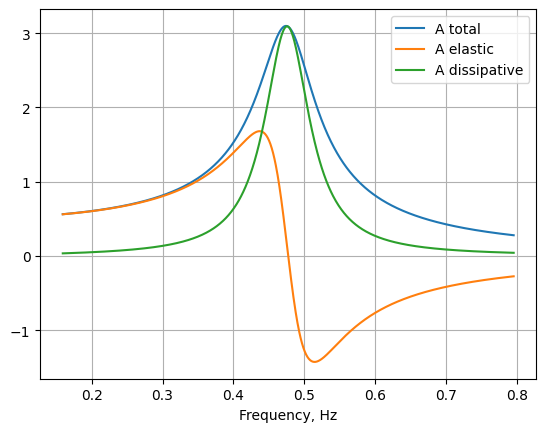

In [15]:
Q = 3
m = 0.236
k1 = 4.5
k = 2* k1
b = np.sqrt(k*m)/Q
eta = 1
pi2 = 2*np.pi
f = eta * k1
def C(omega):
  amp = f/(k - omega**2 - 1.j * omega * b)
  return np.abs(amp), np.real(amp), np.imag(amp)
omega =np.linspace(1,5, 1000)
a, r, i = C(omega)
plt.plot(omega/pi2, a, label='A total')
plt.plot(omega/pi2, r, label='A elastic')
plt.plot(omega/pi2, i, label='A dissipative')
plt.grid()
plt.legend()
plt.xlabel('Frequency, Hz')

# 2-dof. Natural Frequencies w/o friction

## Direct Measurements



In [16]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weight1 = 44.8e-3 #
k1 = weight1 * g /l
mk1 = 17e-3 # kg

# right spring (attached to cart B)
weight2 = 44.8e-3
k2 = weight2 * g /l
mk2 = 17e-3 # kg

# middle spring (between carts A and B)
weight12 = 68.6e-3
k12 = weight12 * g /l
mk12 = 11.7e-3 #

#k12 = k1
#mk12 = mk1

# Carts
m1 = 208.9e-3 #kg
m2 = 208.9e-3

counts = 236
length = 123e-3

## Expected natural frequencies
$$
[ m ] \ddot x + [ k ] x = 0
$$
$$
[m] =  \begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix} ,
$$
$$
[k] = \begin{bmatrix} k_l +k_{12} & -k_{12} \\ -k_{12} & k_{12} +k_2 \end{bmatrix},
$$
Let $Z = [m]^-1 [k]$. Then
eigenvector $λ$ can be found from equation
$$
\rm{det} |Z-\lambda I| =
\begin{vmatrix}
        \frac{k_1 +k_{12}}{m_1} - \lambda & -\frac{k_{12}}{m_1} \\
        -\frac{k_{12}}{m_2} & \frac{k_{12} +k_2}{m_2} - \lambda
        \end{vmatrix}
        = 0
$$
## Effective mass
$$
m_{\rm{cart\ effective}} = m_{\rm{cart}} + \frac{m_{\rm{adjaced\ strings}}}{2}
$$

In [17]:
m1_eff = m1 + mk1/2 + mk12/2
m2_eff = m2 + mk2/2 + mk12/2

M = np.array([[m1_eff, 0],
              [0, m2_eff]])
K = np.array([[k1 + k12, -k12],
              [-k12, k12 + k2]])

# Mechanical impedance matrix
Z = LA.inv(M) @ K
'''
z11 = (k1 + k12)/m1_eff
z12 = k12/m1_eff
z21 = k12/m2_eff
z22 = (k12 + k2)/m2_eff
Z = np.array([[z11, -z12],
              [-z21, z22]])
'''

# E - eigenvectors
eigenvalues, E = LA.eig(Z)

omega_theor = np.sqrt(eigenvalues)
freqs_theor = omega_theor /2 /np.pi # Herz
freqs_theor

array([1.43737772, 0.71313906])

In [18]:
LA.inv(E) @ Z @ E

array([[ 8.15645709e+01,  0.00000000e+00],
       [-3.55271368e-15,  2.00774328e+01]])

In [19]:
E, LA.inv(E), np.transpose(E)

(array([[ 0.70710678,  0.70710678],
        [-0.70710678,  0.70710678]]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [20]:
LA.det(E)

0.9999999999999999

$$ x = E y$$
$$ y = E^{-1} x$$

In [21]:
def xtoy(x1,x2, show=True):
  Einv = LA.inv(E)
  y1 = Einv[0,0] * x1 + Einv[0,1] * x2
  y2 = Einv[1,0] * x1 + Einv[1,1] * x2
  if show:
    plt.plot(t, y1, label='y1')
    plt.plot(t, y2, label='y2')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    plt.legend()
  return y1, y2

## Free oscillations - Mode 1

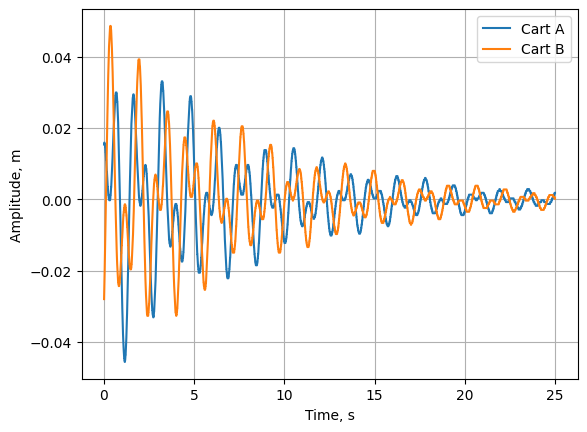

In [22]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/ho_3.txt'
t, x1, x2 = get_signal(url)


[1.43737772 0.71313906]


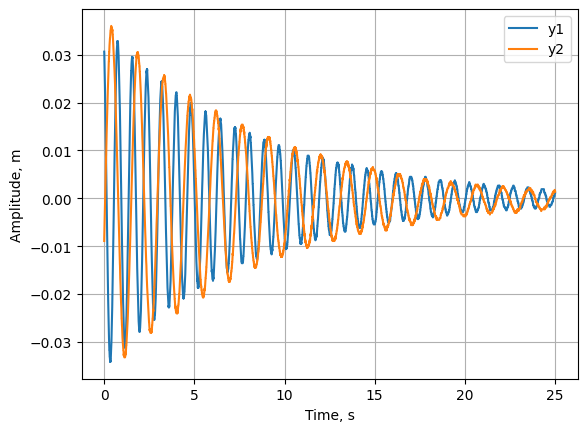

In [23]:
y1, y2 = xtoy(x1, x2)
print(freqs_theor)

In [24]:
get_quality(t, y1)

32.170413609029005

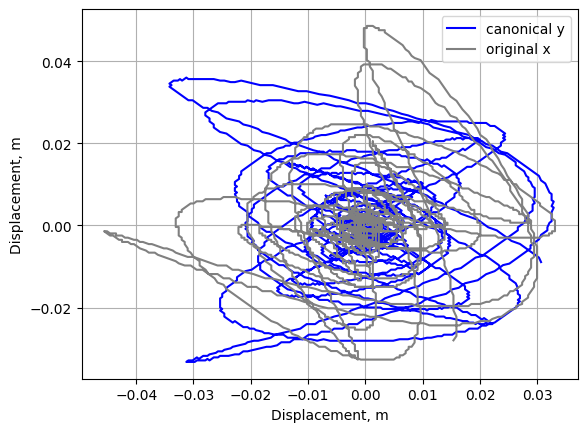

In [25]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

In [26]:
get_frequency(t, y2)

(0.6888681678247134, 0.010622838532809275)

In [27]:
def get_quality(t, harmonic_signal):
  tpeaks, peaks = get_amplitude(t, harmonic_signal)
  decay = np.log(peaks/peaks[0])
  cycles = range(len(peaks))
  fit = linregress(cycles, decay)
  quality = -np.pi/fit.slope
  return quality

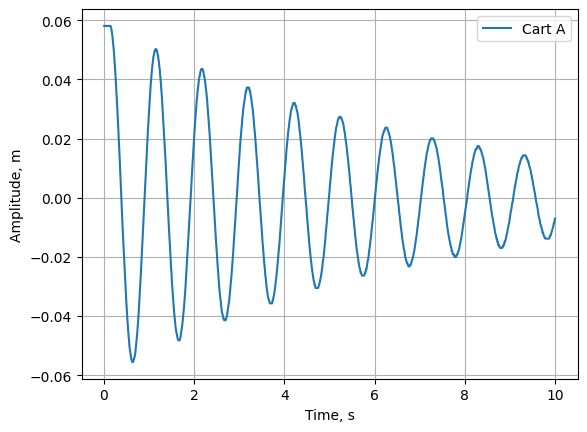

In [28]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/quality/q_1.txt'
t, x = get_signal1(url)

In [29]:
get_quality(t, x)

20.73121950563673

In [30]:
get_frequency(t,x)

(0.9784884827717495, 0.0038073481819909548)

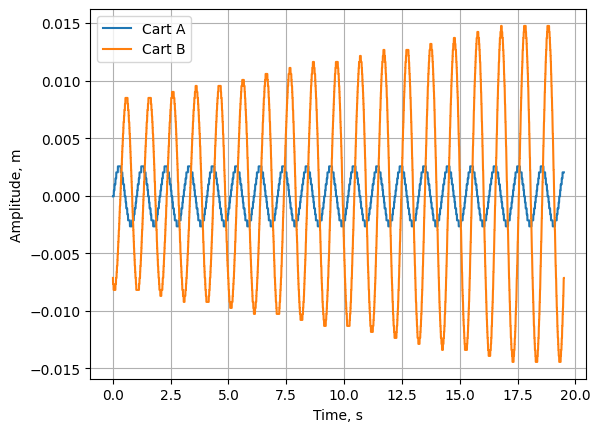

In [31]:
url='https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/quality/q_2.txt'
t, x1, x2 = get_signal(url)

In [32]:
get_frequency(t, x2)

(0.9871399069681451, 0.005194597879261736)

## Free oscillations - Mode 2

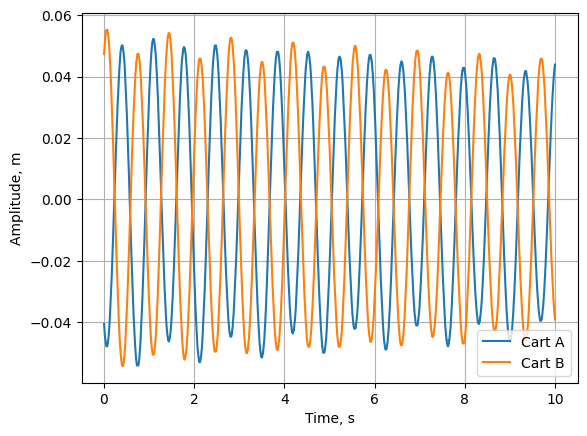

In [33]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_2.txt'
t, x1, x2 = get_signal(url)

[1.43737772 0.71313906]


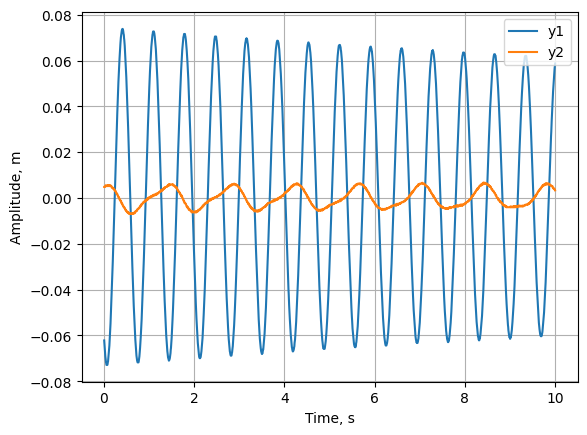

In [34]:
y1, y2 = xtoy(x1, x2)
print(freqs_theor)


In [35]:
get_quality(t, y1)

236.89027646285865

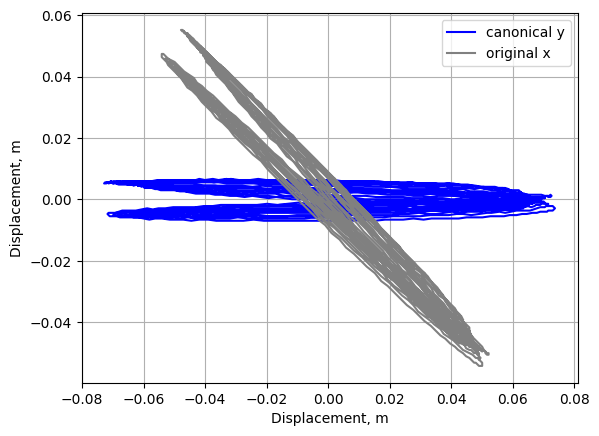

In [36]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

In [37]:
get_frequency(t, y1)


(1.454193201068257, 0.008895549570482653)

## Free oscillations - Mode Superpositions

### Coupled

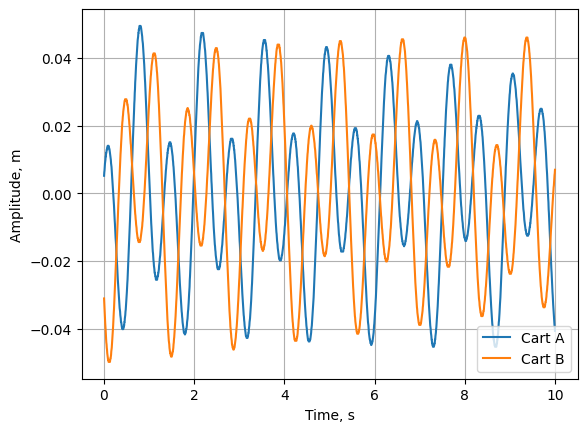

In [38]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_4.txt'
t, x1, x2 = get_signal(url)

### Decoupled

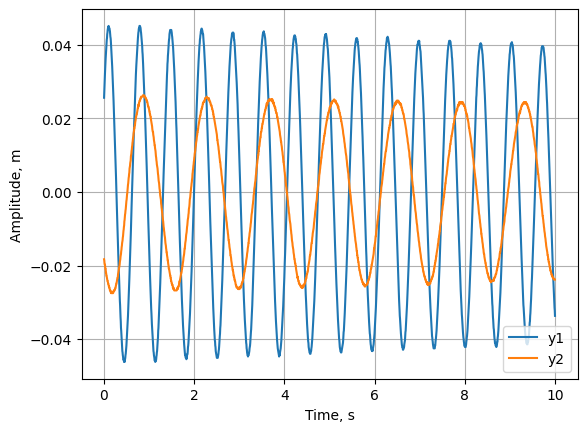

In [39]:
y1, y2 = xtoy(x1, x2)


### Lissajues figures

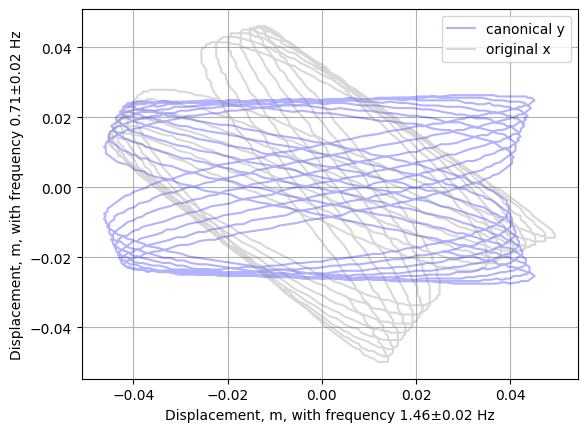

In [40]:
f1, f1u = get_frequency(t, y1)
f2, f2u = get_frequency(t, y2)

plt.plot(y1, y2, color='blue', alpha=0.3, label=f'canonical y')
plt.plot(x1, x2, color='gray', alpha=0.3, label='original x')

#y1_theor = np.max(y1) * np.cos(omega_theor[0]*t)
#y2_theor = np.max(y2) * np.cos(omega_theor[1]*t)
#plt.plot(y1_theor, y2_theor, color='green', alpha=0.3,
#         label=f'Theoretical {freqs_theor[0]:.2f} / {freqs_theor[1]:.2f} Hz')

plt.grid()
plt.xlabel(f'Displacement, m, with frequency {f1:.2f}±{f1u:.2f} Hz')
plt.ylabel(f'Displacement, m, with frequency {f2:.2f}±{f2u:.2f} Hz')
plt.legend();


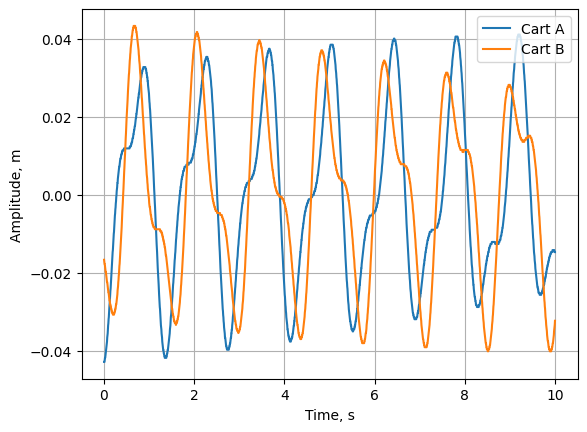

In [41]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/c_5.txt'
t, x1, x2 = get_signal(url)

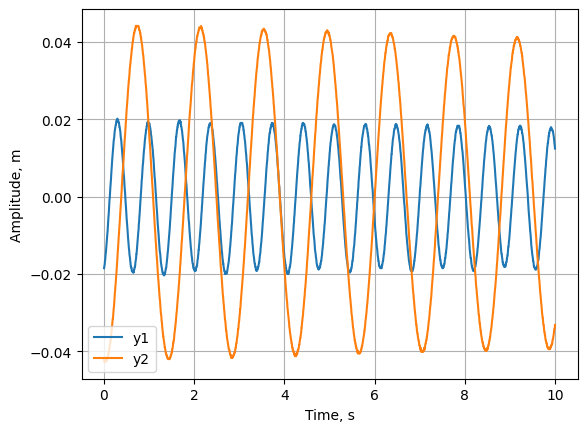

In [42]:
y1, y2 = xtoy(x1, x2)

In [43]:
get_quality(t, x1-x2)

493.53329674584074

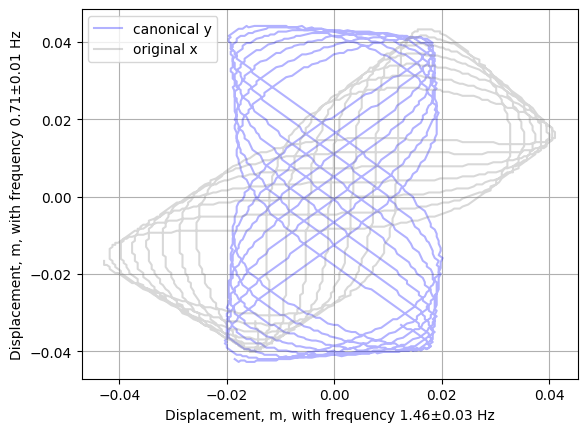

In [44]:
f1, f1u = get_frequency(t, y1)
f2, f2u = get_frequency(t, y2)

plt.plot(y1, y2, color='blue', alpha=0.3, label=f'canonical y')
plt.plot(x1, x2, color='gray', alpha=0.3, label='original x')

plt.grid()
plt.xlabel(f'Displacement, m, with frequency {f1:.2f}±{f1u:.2f} Hz')
plt.ylabel(f'Displacement, m, with frequency {f2:.2f}±{f2u:.2f} Hz')
plt.legend();

# Forced oscillations with friction


http://spiff.rit.edu/classes/phys283/lectures/coupled_rev/coupled_rev.html





$$
M \ddot x + M \Gamma \dot x + K x = F \cos \omega t
$$


## Direct measurements

In [45]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weightl = 44.8e-3 #
kl = weightl * g /l
ml = 17e-3 # kg

# right spring (attached to cart B)
weightr = 44.8e-3
kr = weightr * g /l
mr = 17e-3 # kg

# middle spring (between carts A and B)
weightc = 68.6e-3
kc = weightc * g /l
mc = 11.7e-3 #

# Carts (5A, 6B, 6C)
m1 = 208.9e-3 #kg
m2 = 213.8e-3
counts = 236
length = 123e-3

## Expected natural frequencies

In [46]:
m1_eff = m1 + ml/2 + mc/2
m2_eff = m2 + mc/2 + mr/2

M = np.array([[m1_eff, 0],
              [0, m2_eff]])
K = np.array([[kl + kc, -kc],
              [-kc, kc + kr]])

F = np.array([1, 0])  # force applied only to 1st mass



# Mechanical impedance matrix
Z = LA.inv(M) @ K

eigenvalues, E = LA.eig(Z)
freqs_theor = np.sqrt(eigenvalues)/2/np.pi # Herz
freqs_theor

array([1.42966672, 0.70924425])

In [47]:
LA.inv(E) @ Z @ E

array([[8.06917902e+01, 0.00000000e+00],
       [1.77635684e-15, 1.98587259e+01]])

In [48]:
LA.inv(E) @  F

array([0.70965035, 0.69689403])

In [49]:
def get_signal3(url, show=True):
  data = np.loadtxt(url)
  _, t, a, b, c = data.T
  x1 = c/counts * length
  x2 = b/counts * length
  x3 = a/counts * length
  x1 -= x1.mean()
  x2 -= x2.mean()
  x3 -= x3.mean()
  if show:
    plt.plot(t, x1, label='Cart A')
    plt.plot(t, x2, label='Cart B')
    plt.plot(t, x3, label='Forced cart')
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Amplitude, m')
    #plt.ylim(-length/2, length/2)
    plt.legend()
  return t, x1, x2, x3




## Energy responce to forced oscillations

### Energy associated with main variables

$$
E_i \approx \frac{1}{2} A_i^2 \omega_i^2
$$

In [50]:
def energy(t, oscillator, show=False):
  f0, f0_unc = get_frequency(t, oscillator)
  tpeaks, amplitude = get_amplitude(t, oscillator)
  omega0 = f0 * 2 * np.pi
  en = (amplitude * omega0)**2 /2
  if show:
    plt.plot(tpeaks, en )
    plt.grid()
    plt.xlabel('Time, s')
    plt.ylabel('Energy, (A omega)^2 /2')
  return np.mean(en)

### Potential energy

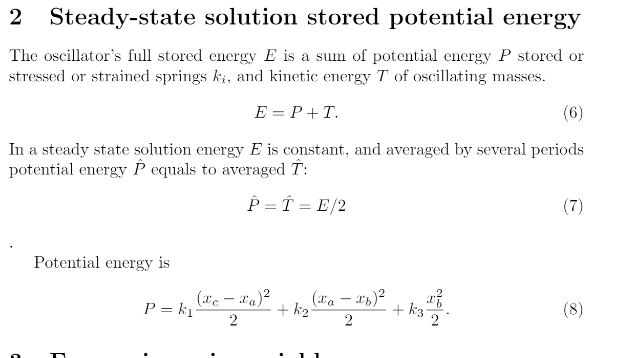

In [51]:
def potential(t, x1, x2, x3):
  p  = kl/2 * (x3 - x2)**2
  p += kc/2 * (x1 - x2)**2
  p += kr/2 * x1**2
  return p.mean()

fc_1 0.5
fc_2 0.64
fc_4 0.72
fc_5 0.74
fc_6 0.78
fc_7 0.78
fc_8 0.8400000000000001
fc_9 0.88
fc_10 1.22
fc_11 1.24
fc_12 1.2800000000000002
fc_13 1.32
fc_14 1.16
fc_18 0.82
fc_19 0.78
fc_20 0.74
fc_21 1.2199999999999998
fc_22 1.2400000000000002
fc_23 1.18
fc_24 1.1400000000000001
fc_25 1.14
fc_26 1.1
fc_27 0.96
fc_28 0.84
fc_29 0.82
fc_30 0.76
fc_31 0.72
fc_32 0.7
fc_33 0.68
fc_34 0.66
fc_35 0.6000000000000001


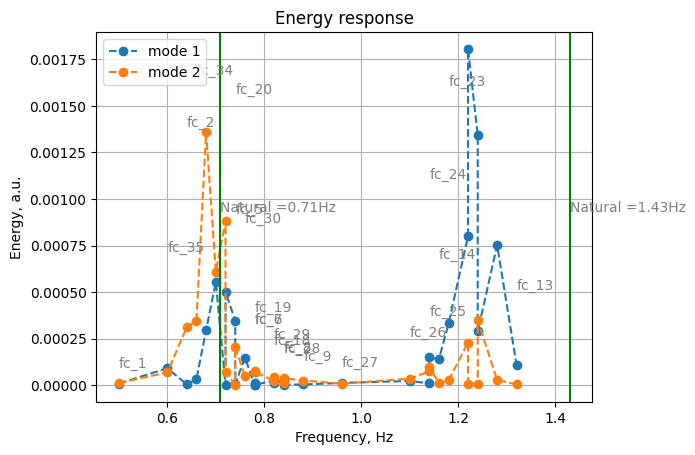

In [52]:
#names = ['fc1', 'fc2', 'fc3', 'fc4', 'fc4.5','fc5', 'fc6', 'fc7', 'fc7.9',  'fc8.2', 'fc8']
names = [f'fc_{i}' for i in range(1,36) if i not in [3,16, 15,17]]
fw = np.array([])
en1 = np.array([])
en2 = np.array([])
poten = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/{name}.txt'
  t, x1, x2, x3 = get_signal3(url, show=False)
  y1, y2 = xtoy(x1, x2, show=False) # to canonic variables
  fw = np.append(fw, get_frequency_fft(t, x3)) # get driver frequency
  print(name, fw[-1])
  en1 = np.append(en1, energy(t, y1)) # energy in 1st canonic var
  en2 = np.append(en2, energy(t, y2)) # energy in 2nd
  #poten = np.append(poten, potential(t, x1, x2, x3))

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], m1_eff*en1[idx], linestyle='--', marker='o', label='mode 1')
plt.plot(fw[idx], m2_eff*en2[idx], linestyle='--', marker='o', label='mode 2')
#plt.plot(fw[idx], 2*poten[idx], linestyle='--', marker='o', label='PE+KE')
for ind in idx:
  plt.annotate(names[ind], xy=(fw[ind], en1[ind]+en2[ind]), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel('Energy, a.u.')
plt.title('Energy response')
for freq in freqs_theor:
  plt.axvline(freq, c='g')
  plt.annotate(fr'Natural ={freq:.2f}Hz',xy=(freq, np.mean(en1+en2)/2), color='gray')
plt.legend();

## Forced oscillations in resonance and out of resonance

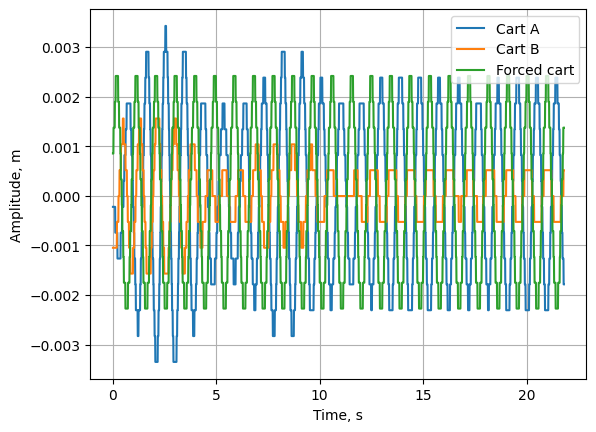

In [53]:
# Mode 1
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/fc_15.txt'
t, x1, x2, x3 = get_signal3(url)

In [54]:
get_frequency(t, x3)

(1.0582067010371812, 0.0024436770760719894)

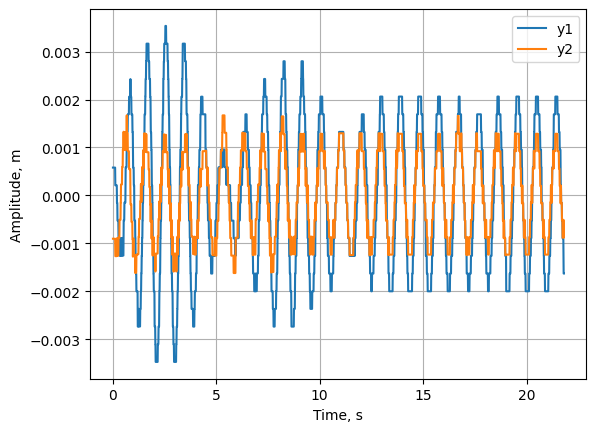

In [55]:
y1, y2 = xtoy(x1, x2)

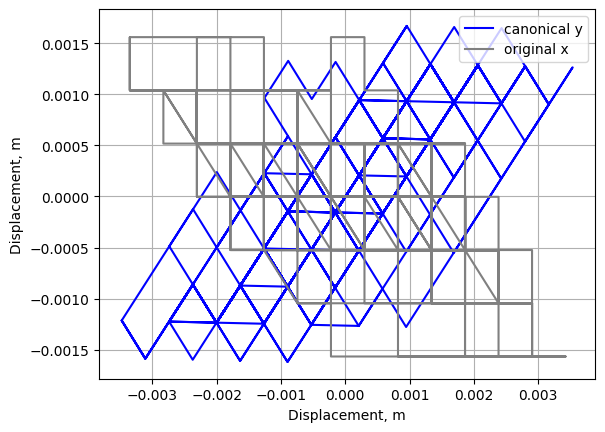

In [56]:
plt.plot(y1, y2, color='blue', label='canonical y')
plt.plot(x1, x2, color='gray', label='original x')
plt.grid()
plt.xlabel('Displacement, m')
plt.ylabel('Displacement, m')
plt.legend();

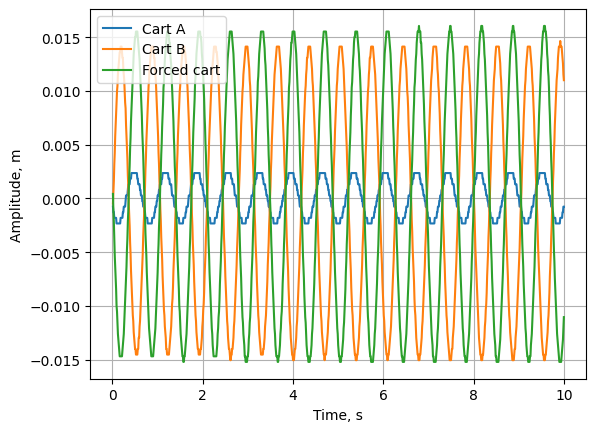

In [57]:
# Mode 2
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc7.9.txt'
t, x1, x2, x3 = get_signal3(url)

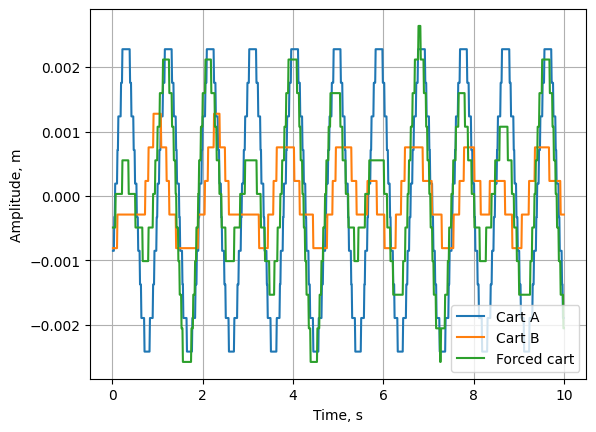

In [58]:
# No resonance
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/fc6.txt'
t, x1, x2, x3 = get_signal3(url)

## Lissajous

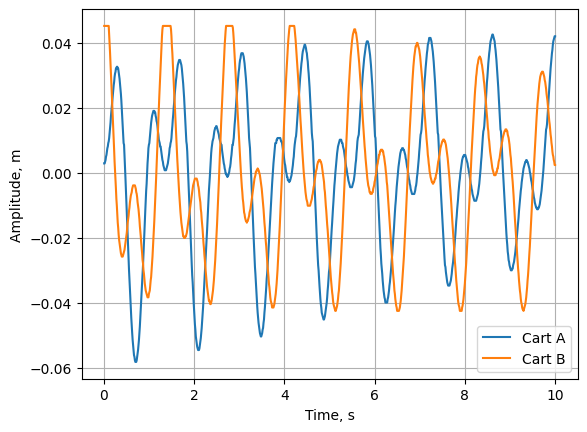

In [59]:
url  = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/ho_weakly.txt'
t, x1, x2 = get_signal(url)
y1, y2 = xtoy(x1, x2, show=False)

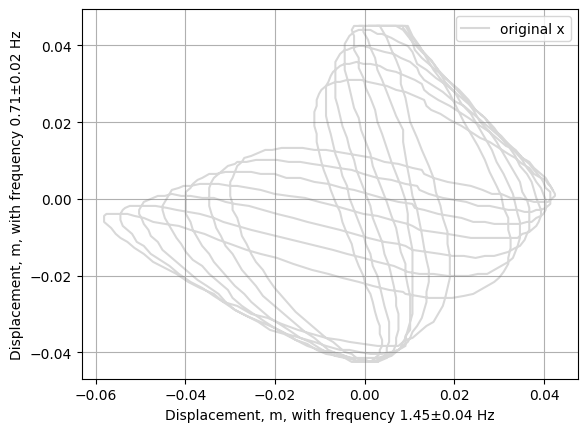

In [60]:
f1, f1u = get_frequency(t, y1)
f2, f2u = get_frequency(t, y2)

#plt.plot(y1, y2, color='blue', alpha=0.3, label=f'canonical y')
plt.plot(x1, x2, color='gray', alpha=0.3, label='original x')

plt.grid()
plt.xlabel(f'Displacement, m, with frequency {f1:.2f}±{f1u:.2f} Hz')
plt.ylabel(f'Displacement, m, with frequency {f2:.2f}±{f2u:.2f} Hz')
plt.legend();

# Steady-state oscillations as a function of driving displacemet $\eta(t) = \eta_0 \cos\omega t$

$$
m_1 \ddot x_1 = -k_1(x_1 - \eta) + k_{c}(x_2 - x_1) - b_1 \dot x\\
m_2 \ddot x_2 = -k_c(x_2 - x_1) + k_2 x_2 - b_2 \dot x\\
$$
Steady-state solution
$$
x_i(t) = C_i \cos\omega t
$$

## Direct measurements

In [61]:
# Springs
l = 97.95e-3 # m, spring strain
g = 9.8 # m/s^2

# left spring (attached to cart A)
weightl = 44.8e-3 #
k1 = weightl * g /l
mk1 = 17e-3 # kg

# right spring (attached to cart B)
weightr = 44.8e-3
k2 = weightr * g /l
mk2 = 17e-3 # kg

# middle spring (between carts A and B)
#weightc = 68.6e-3
weightc = 44.8e-3
kc = weightc * g /l
mkc = 11.7e-3 #

# Carts (5A, 6B, 6C)
m1 = 208.9e-3 #kg
m2 = 213.8e-3
counts = 236
length = 123e-3

# Quality factors (found by observation of free dumped oscillations)
Q1 = 20
Q2 = 20
b1 = np.sqrt((k1+kc) * m1_eff) / Q1
b2 = np.sqrt((k2+kc) * m2_eff) / Q2


## Expected freqs and amplitudes

$$
Z(\omega) =  
\begin{bmatrix}
-m_1 \omega^2 +k_1 + k_c & -k_c \\
-k_c & -m_2 \omega^2 +k_2 + k_c
\end{bmatrix} ,
$$
Amplitudes
$$
C =  
\begin{bmatrix}
C_1 \\
C_2
\end{bmatrix} ,
$$
Driving forces
$$
F =  
\begin{bmatrix}
\eta k_1 \\
0
\end{bmatrix} ,
$$
$$
Z(\omega) C = F \rightarrow C = Z(\omega)^{-1} F  $$


In [62]:
m1_eff = m1 + mk1/2 + mkc/2
m2_eff = m2 + mkc/2 + mk2/2

M = np.array([[m1_eff, 0],
              [0, m2_eff]])
K = np.array([[k1 + kc, -kc],
              [-kc, kc + k2]])
B = np.array([[b1, 0],
              [0, b2]])

eta = 5e-3 # mm
F = np.array([
              [k1*eta],
              [0]
              ])  # force applied only to 1st mass

# Mechanical impedance matrix
Z = LA.inv(M) @ K

# E - eigenvectors
eigenvalues, E = LA.eig(Z)
omega_theor = np.sqrt(eigenvalues)
pi2 = 2 * np.pi
omega_theor /pi2

array([1.22857928, 0.709237  ])

In [63]:
def C(omega):

  def complex2real(amplitude):
    a = np.abs(amplitude)
    sign = np.sign(np.real(amplitude))
    return a* sign

  z = K - M * omega**2 - 1.j *omega * B
  zinv = LA.inv(z)
  c = zinv @ F
  # first amplitude complex
  c1 = c[0][0]
  c1r = complex2real(c1)
  # second amplitude complex
  c2 = c[1][0]
  c2r = complex2real(c2)
  return c1r, c2r



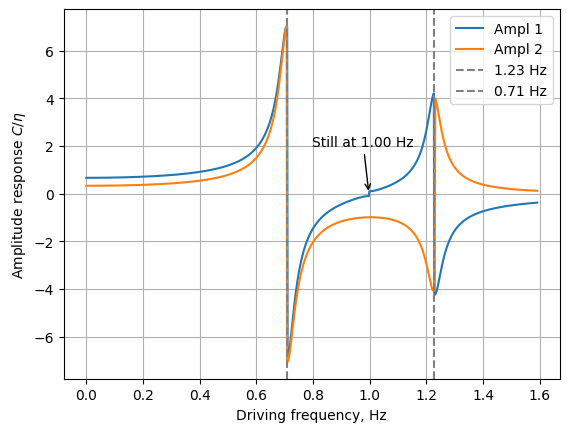

In [64]:
# Amplitudes
omegas = np.linspace(0,10, 1000)

c = np.array([C(omega) for omega in omegas]).T /eta

plt.plot(omegas/pi2, c[0],  label='Ampl 1')
plt.plot(omegas/pi2, c[1],  label='Ampl 2')
for nat in omega_theor/pi2:
  plt.axvline(nat,  color='gray', linestyle='--', label=f'{nat:.2f} Hz')
plt.grid()
plt.legend()
plt.xlabel(r'Driving frequency, Hz')
plt.ylabel('Amplitude response $C/\eta$')

#plt.ylim(-5, 5)
#plt.yticks(np.arange(-5, 5))

# c1 becomes zero between resonance frequencies
still_ind = np.argmin(np.abs(c[0]))
still_freq = omegas[still_ind] / pi2
xy = (still_freq, 0)
xytext = (omegas[still_ind] / pi2 - 0.2, 2)
plt.annotate(f'Still at {still_freq:.2f} Hz', xy=xy, xytext=xytext,
            arrowprops=dict(facecolor='gray', arrowstyle="->"),
            );




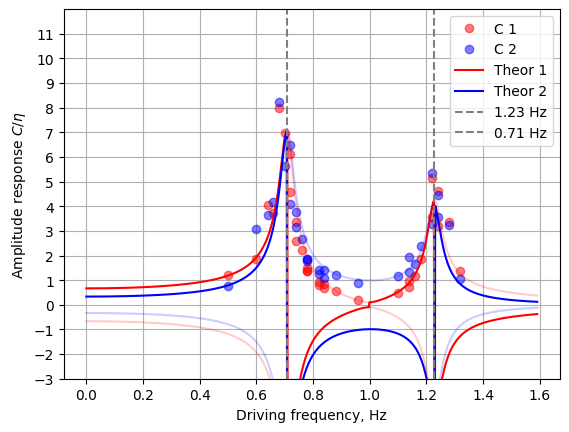

In [65]:
names = [f'fc_{i}' for i in range(1,36) if i not in [3,16, 15,17]]
fw = np.array([])
c1 = np.array([])
c2 = np.array([])
for name in names:
  url = f'https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_Coupled_Oscillator/main/2311/{name}.txt'
  t, x1, x2, x3 = get_signal3(url, show=False)
  # get driver frequency
  fw = np.append(fw, get_frequency_fft(t, x3))
  # get driver amplitude
  _, amps = get_amplitude(t, x3)
  eta = np.mean(amps)
  # get mass1 amplitude
  _, amps = get_amplitude(t, x2)
  c1 = np.append(c1, np.mean(amps)/eta) #* np.sign(x2 @ x3)
  # get mass2 amplitude
  _, amps = get_amplitude(t, x1)
  c2 = np.append(c2, np.mean(amps)/eta) #* np.sign(x1 @ x3)

  #print(f'{name}, {fw[-1]:.2f} Hz, {c1[-1]:.1f}, {c2[-1]:.1f} s{x1@x3:.1e}')

idx = np.argsort(fw) # sorting
plt.plot(fw[idx], c1[idx],  alpha=0.5, linestyle=' ', marker='o', c='red', label='C 1')
plt.plot(fw[idx], c2[idx],  alpha=0.5, linestyle=' ', marker='o', c='blue', label='C 2')


#for ind in idx:
  #plt.annotate(names[ind], xy=(fw[ind], (c1[ind]+c2[ind])/2), color='gray')
plt.grid()
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude response')

# theory
plt.plot(omegas/pi2, c[0],  c='red', label='Theor 1')
plt.plot(omegas/pi2, c[1],  c='blue', label='Theor 2')

plt.plot(omegas/pi2, -c[0],  c='red', alpha=0.2 )
plt.plot(omegas/pi2, -c[1],  c='blue', alpha=0.2)

for nat in omega_theor/pi2:
  plt.axvline(nat,  color='gray', linestyle='--', label=f'{nat:.2f} Hz')
plt.legend()
plt.xlabel(r'Driving frequency, Hz')
plt.ylabel('Amplitude response $C/\eta$')
plt.ylim(-3, 12)
plt.yticks(np.arange(-3, 12))


plt.legend();

In [66]:
x1 @ x3

-0.004858280949559513